In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('data.csv')
df = df[['close','symbol']]

rer = pd.DataFrame()
for i in df.symbol.unique():
    rer[f'{i}'] = df[df['symbol'] == f'{i}'].reset_index().drop(columns=['index','symbol']).rename(columns={'close':f'{i}'})

df = rer.dropna(axis=1, how='any')

In [3]:
df

,BTCUSDT,ETHUSDT,BNBUSDT,LTCUSDT,ADAUSDT,XRPUSDT,XLMUSDT,TRXUSDT,ETCUSDT,LINKUSDT,...,HBARUSDT,BCHUSDT,SOLUSDT,DOTUSDT,UNIUSDT,AVAXUSDT,AAVEUSDT,NEARUSDT,SHIBUSDT,ICPUSDT
0,18461.36,1245.78,264.00,51.09,0.4389,0.3936,0.1105,0.05905,27.73,6.680,...,0.05650,108.9,30.65,6.120,5.340,16.55,71.60,3.641,0.000010,5.910
1,19401.63,1326.46,275.30,53.57,0.4584,0.4862,0.1230,0.06022,28.62,7.123,...,0.06000,116.5,32.43,6.450,5.740,17.68,76.70,3.865,0.000011,6.080
2,19289.91,1327.25,276.70,55.22,0.4618,0.5069,0.1232,0.06042,28.88,7.449,...,0.06110,120.1,33.66,6.440,5.910,17.97,77.10,3.792,0.000011,6.220
3,18920.50,1317.13,274.40,53.43,0.4511,0.4878,0.1179,0.05985,28.67,7.629,...,0.06100,117.3,33.38,6.270,5.800,17.60,75.00,3.699,0.000011,6.050
4,18807.38,1294.63,274.30,52.53,0.4464,0.4917,0.1173,0.05970,28.37,7.865,...,0.05890,113.5,32.34,6.200,5.660,17.32,73.60,3.649,0.000011,5.900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,105671.73,2642.65,654.75,86.13,0.6613,2.1899,0.2673,0.27180,17.11,13.970,...,0.16288,424.0,152.32,3.919,7.489,20.28,293.92,2.369,0.000012,5.821
996,106066.59,2579.19,655.35,86.55,0.6420,2.1472,0.2608,0.26970,16.90,13.440,...,0.15899,448.7,148.60,3.838,7.759,19.41,291.17,2.240,0.000012,5.458
997,105414.64,2530.76,645.61,85.18,0.6247,2.1394,0.2564,0.27110,16.63,13.150,...,0.15497,430.9,144.64,3.781,7.302,18.93,275.11,2.232,0.000012,5.480
998,105594.01,2547.61,648.19,86.30,0.6334,2.1655,0.2587,0.27390,16.68,13.300,...,0.15443,460.4,152.97,3.821,7.180,19.10,274.97,2.228,0.000012,5.516


# Solver

In [4]:
def find_optimal_parameters(df, symbol_list=None, 
                            min_last_days=90, max_last_days=1000, step_day=1,
                            min_procent=0.01, max_procent=0.4, step_procent=0.05,
                            min_std_procent=0.01, max_std_procent=0.2, step_std=0.01):
    results = {}

    if symbol_list is None:
        symbol_list = df.columns.tolist()

    for symbol in symbol_list:
        optimal_procent = max_procent
        optimal_last_days = min_last_days
        optimal_std_procent = max_std_procent

        for last_days in range(min_last_days, max_last_days + 1, step_day):
            df_slice = df[symbol].iloc[-last_days:]
            mean_val = df_slice.mean()

            for std_procent in np.arange(max_std_procent, min_std_procent, -step_std):
                std_n = mean_val * std_procent

                for procent in np.arange(max_procent, min_procent, -step_procent):
                    min_historical = df[symbol].min() * (procent + 1.0)
                    min_support = df_slice.min() * (procent + 1.0)

                    if df_slice.std() <= std_n and mean_val <= min_historical:
                        if (procent < optimal_procent or
                            (procent == optimal_procent and last_days > optimal_last_days) or
                            (procent == optimal_procent and last_days == optimal_last_days and std_procent < optimal_std_procent)):
                            optimal_procent = procent
                            optimal_last_days = last_days
                            optimal_std_procent = std_procent

        last_price = df[symbol].iloc[-1]

        results[symbol] = (optimal_procent, optimal_last_days, optimal_std_procent, min_support, min_historical, last_price)

    results = pd.DataFrame(results).T
    results.columns = ['Optimal Procent', 'Optimal Last Days', 'Optimal Std Procent', 'Min Support', 'Min Historical', 'Last Price']
    results = results.sort_values(by=['Optimal Procent', 'Optimal Last Days', 'Optimal Std Procent'], 
                                    ascending=[True, False, False])

    return results

In [5]:
optimal_symbol = find_optimal_parameters(
    df, symbol_list=None, 
    min_last_days=30, max_last_days=100, step_day=5,
    min_procent=0.01, max_procent=1.0, step_procent=0.05,
    min_std_procent=0.01, max_std_procent=0.4, step_std=0.01
)

In [6]:
optimal_symbol

,Optimal Procent,Optimal Last Days,Optimal Std Procent,Min Support,Min Historical,Last Price
DOTUSDT,0.25,100.0,0.10,3.546900,3.546900,3.987000
ETCUSDT,0.25,100.0,0.08,14.773500,14.773500,17.480000
UNIUSDT,0.55,80.0,0.14,5.014800,4.082400,7.838000
LTCUSDT,0.75,95.0,0.10,72.607500,52.909500,88.710000
ICPUSDT,0.80,80.0,0.08,4.816350,3.046050,5.632000
ETHUSDT,0.95,100.0,0.19,1547.080500,1157.866500,2665.450000
BTCUSDT,1.00,30.0,0.40,80138.541000,16570.354500,108684.690000
BNBUSDT,1.00,30.0,0.40,558.064500,215.355000,658.080000
ADAUSDT,1.00,30.0,0.40,0.586215,0.254205,0.655600
XRPUSDT,1.00,30.0,0.40,1.886115,0.349755,2.322500


In [7]:
result = optimal_symbol.head(5).index.to_list()

In [8]:
result

['DOTUSDT', 'ETCUSDT', 'UNIUSDT', 'LTCUSDT', 'ICPUSDT']

# Побудова графіку

In [9]:
def paint_result(df, result, info_df, last_days=1000):
    num_columns = len(result)
    fig, axes = plt.subplots(nrows=num_columns, ncols=1, figsize=(16, 6 * num_columns))

    if num_columns == 1:
        symbol = result[0]
        series = df[symbol].iloc[-last_days:]
        series.plot(ax=axes)
        axes.axhline(info_df.loc[symbol, 'Min Historical'], color='red', linestyle='--', label='Min Historical')
        axes.axhline(info_df.loc[symbol, 'Min Support'], color='orange', linestyle='--', label='Min Support')
        axes.axhline(info_df.loc[symbol, 'Last Price'], color='green', linestyle='--', label='Last Price')
        axes.set_title(f"{symbol}")
        axes.legend()
    else:
        for idx, symbol in enumerate(result):
            series = df[symbol].iloc[-last_days:]
            series.plot(ax=axes[idx])
            axes[idx].axhline(info_df.loc[symbol, 'Min Historical'], color='red', linestyle='--', label='Min Historical')
            axes[idx].axhline(info_df.loc[symbol, 'Min Support'], color='orange', linestyle='--', label='Min Support')
            axes[idx].axhline(info_df.loc[symbol, 'Last Price'], color='green', linestyle='--', label='Last Price')
            axes[idx].set_title(f"{symbol}")
            axes[idx].legend()

    plt.tight_layout()
    plt.show()


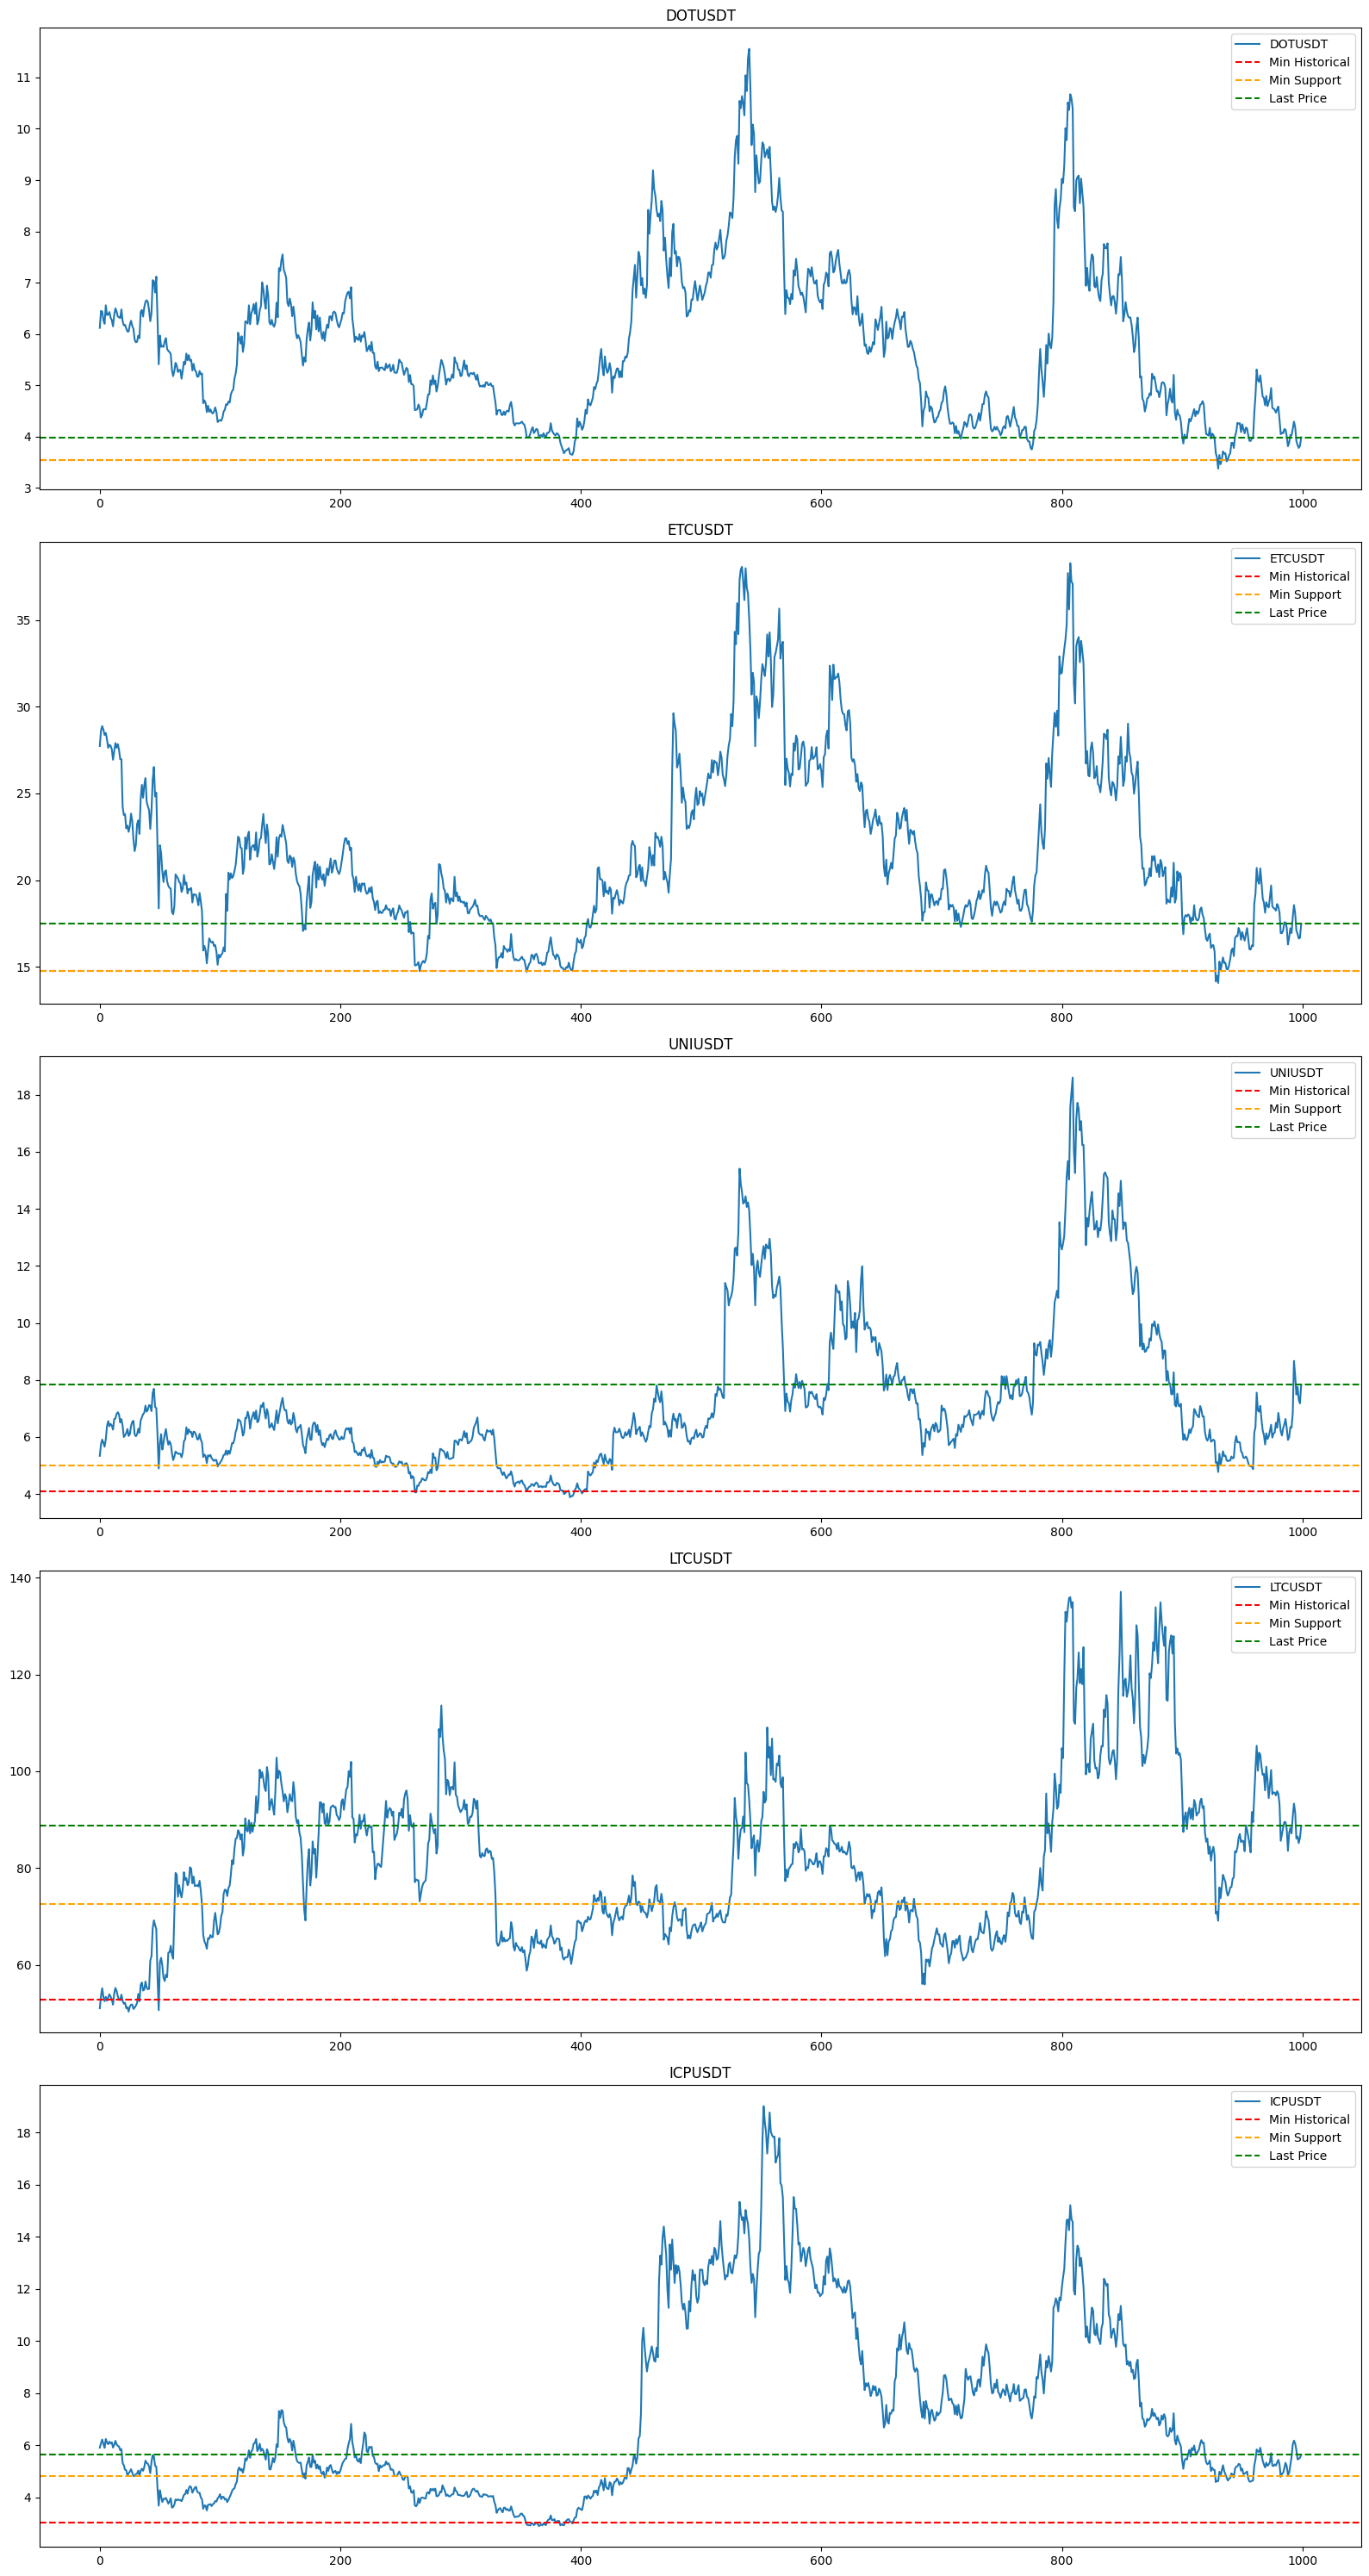

In [10]:
paint_result(df, result, optimal_symbol, last_days=1000)

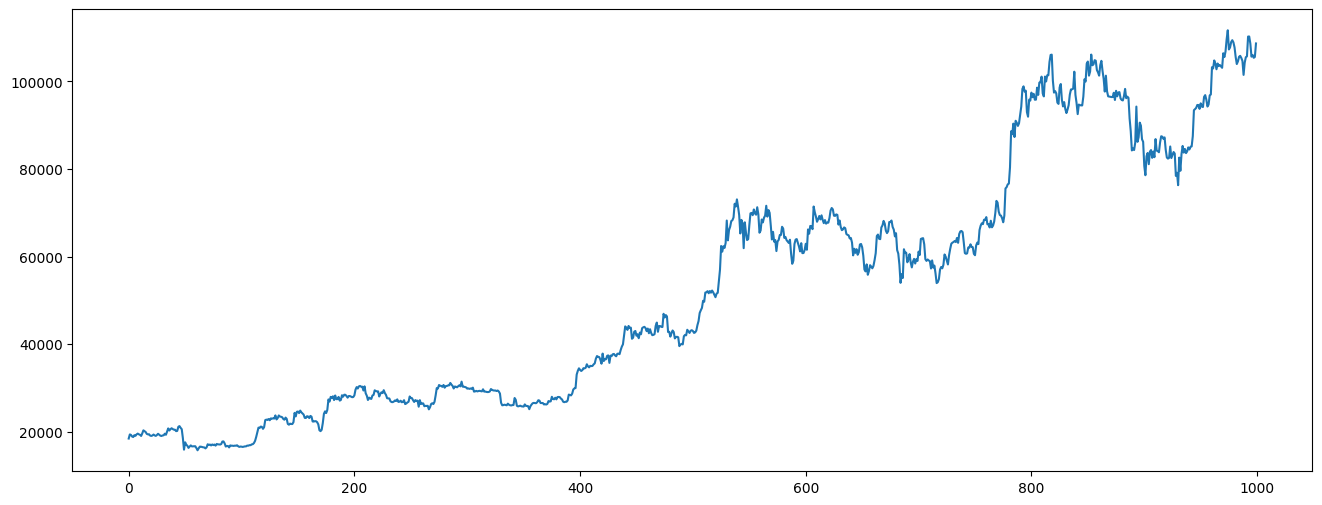

In [11]:
plt.figure(figsize=(16, 6))
df['BTCUSDT'].plot()
plt.show()